---------
### Lending Club Data Analysis: Application of Machine Learning techniques to Loan Default Prediction
--------
- Data: https://www.lendingclub.com/auth/login?login_url=%2Fstatistics%2Fadditional-statistics%3F
- Project contributors: Ali Murad, Brandon Moragne, and Maycie Mckay

In [537]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np
import math
import random
import seaborn as sns
import warnings 
warnings.simplefilter('ignore')
# from string import isdigit
import matplotlib.pyplot as plt
%matplotlib inline

In [538]:
loans = pd.read_csv('CleanedData.csv', index_col='id')

In [539]:
# Create a copy of the main dataframe
loans2 = loans.copy()
print(loans2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 917472 entries, 68407277 to 88224441
Columns: 106 entries, loan_amnt to debt_settlement_flag
dtypes: float64(83), object(23)
memory usage: 749.0+ MB
None


------------
## Data pre-processing
------------

In [540]:
# clean data and convert variables from object to float
# loans2['emp_length'] = loans2['emp_length'].map(lambda x: x.lstrip('+-').rstrip('+ years'))
loans2['emp_length'] = loans2['emp_length'].str.extract('(\d+)').astype('float64')
loans2['zip_code'] = loans2['zip_code'].str.extract('(\d+)').astype('float64')

In [541]:
#convert dates to datetime and get months
loans2['issue_d'] = pd.to_datetime(loans2['issue_d']).dt.month_name()
loans2['earliest_cr_line'] = pd.to_datetime(loans2['earliest_cr_line']).dt.month_name()
loans2['last_pymnt_d'] = pd.to_datetime(loans2['last_pymnt_d']).dt.month_name()
loans2['last_credit_pull_d'] = pd.to_datetime(loans2['last_credit_pull_d']).dt.month_name()

In [542]:
#drop column url
loans2.drop(columns=['url'], inplace=True)
loans2.head(3)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
68407277,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10.0,MORTGAGE,55000.0,Not Verified,December,Fully Paid,n,debt_consolidation,Debt consolidation,190.0,PA,5.91,0.0,August,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,0.0,0.0,4421.723917,4421.72,3600.0,821.72,0.0,0.0,0.0,January,122.67,March,564.0,560.0,0.0,1.0,Individual,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
68355089,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10.0,MORTGAGE,65000.0,Not Verified,December,Fully Paid,n,small_business,Business,577.0,SD,16.06,1.0,December,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,0.0,0.0,25679.660000,25679.66,24700.0,979.66,0.0,0.0,0.0,June,926.35,March,699.0,695.0,0.0,1.0,Individual,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
68476807,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,3.0,MORTGAGE,104433.0,Source Verified,December,Fully Paid,n,major_purchase,Major purchase,174.0,PA,25.37,1.0,June,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,w,0.0,0.0,11740.500000,11740.50,10400.0,1340.50,0.0,0.0,0.0,July,10128.96,March,704.0,700.0,0.0,1.0,Individual,0.0,0.0,331730.0,1.0,3.0,0.0,3.0,14.0,73839.0,84.0,4.0,7.0,9702.0,78.0,34000.0,2.0,1.0,3.0,10.0,27644.0,4567.0,77.5,0.0,0.0,128.0,210.0,4.0,4.0,6.0,4.0,1.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N


In [543]:
#re arrange columns so that the target column(loan_status) is the last column of the dataframe
cols = list(loans2.columns.difference(['loan_status']))
cols.append('loan_status')
loans2 = loans2[cols]

In [544]:
loans2.head()

,acc_now_delinq,acc_open_past_24mths,addr_state,all_util,annual_inc,application_type,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collection_recovery_fee,collections_12_mths_ex_med,debt_settlement_flag,delinq_2yrs,delinq_amnt,disbursement_method,dti,earliest_cr_line,emp_length,emp_title,fico_range_high,fico_range_low,funded_amnt,funded_amnt_inv,grade,hardship_flag,home_ownership,il_util,initial_list_status,inq_fi,inq_last_12m,inq_last_6mths,installment,int_rate,issue_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,last_pymnt_amnt,last_pymnt_d,loan_amnt,max_bal_bc,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_rcnt_il,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,open_acc_6m,open_act_il,open_il_12m,open_il_24m,open_rv_12m,open_rv_24m,out_prncp,out_prncp_inv,pct_tl_nvr_dlq,percent_bc_gt_75,policy_code,pub_rec,pub_rec_bankruptcies,purpose,pymnt_plan,recoveries,revol_bal,revol_util,sub_grade,tax_liens,term,title,tot_coll_amt,tot_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bal_il,total_bc_limit,total_cu_tl,total_il_high_credit_limit,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,verification_status,zip_code,loan_status
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
68407277,0.0,4.0,PA,34.0,55000.0,Individual,20701.0,1506.0,37.2,0.0,0.0,0.0,N,0.0,0.0,Cash,5.91,August,10.0,leadman,679.0,675.0,3600.0,3600.0,C,N,MORTGAGE,36.0,w,3.0,4.0,1.0,123.03,13.99,December,March,564.0,560.0,122.67,January,3600.0,722.0,148.0,128.0,3.0,3.0,1.0,21.0,4.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,7.0,2.0,2.0,0.0,1.0,3.0,3.0,0.0,0.0,76.9,0.0,1.0,0.0,0.0,debt_consolidation,n,0.0,2765.0,29.7,C4,0.0,36 months,Debt consolidation,722.0,144904.0,178050.0,13.0,7746.0,4981.0,2400.0,1.0,13734.0,4421.723917,4421.72,821.72,0.0,3600.0,9300.0,Not Verified,190.0,Fully Paid
68355089,0.0,4.0,SD,29.0,65000.0,Individual,9733.0,57830.0,27.1,0.0,0.0,0.0,N,1.0,0.0,Cash,16.06,December,10.0,Engineer,719.0,715.0,24700.0,24700.0,C,N,MORTGAGE,73.0,w,0.0,6.0,4.0,820.28,11.99,December,March,699.0,695.0,926.35,June,24700.0,6472.0,113.0,192.0,2.0,2.0,4.0,19.0,2.0,0.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,22.0,1.0,1.0,0.0,1.0,2.0,3.0,0.0,0.0,97.4,7.7,1.0,0.0,0.0,small_business,n,0.0,21470.0,19.2,C1,0.0,36 months,Business,0.0,204396.0,314017.0,38.0,39475.0,18005.0,79300.0,0.0,24667.0,25679.660000,25679.66,979.66,0.0,24700.0,111800.0,Not Verified,577.0,Fully Paid
68476807,0.0,10.0,PA,78.0,104433.0,Individual,27644.0,4567.0,77.5,0.0,0.0,0.0,N,1.0,0.0,Cash,25.37,June,3.0,Contract Specialist,699.0,695.0,10400.0,10400.0,F,N,MORTGAGE,84.0,w,2.0,3.0,3.0,289.91,22.45,December,March,704.0,700.0,10128.96,July,10400.0,9702.0,128.0,210.0,4.0,4.0,6.0,14.0,4.0,1.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,12.0,1.0,3.0,0.0,3.0,4.0,7.0,0.0,0.0,96.6,60.0,1.0,0.0,0.0,major_purchase,n,0.0,21929.0,64.5,F1,0.0,60 months,Major purchase,0.0,331730.0,439570.0,35.0,95768.0,73839.0,20300.0,1.0,88097.0,11740.500000,11740.50,1340.50,0.0,10400.0,34000.0,Source Verified,174.0,Fully Paid
68476668,0.0,6.0,MN,74.0,180000.0,Individual,30030.0,0.0,102.9,0.0,0.0,0.0,N,0.0,0.0,Cash,14.67,June,10.0,Vice President of Recruiting Operations,684.0,680.0,20000.0,20000.0,B,N,MORTGAGE,63.0,f,1.0,1.0,0.0,637.58,9.17,December,March,654.0,650.0,15681.05,November,20000.0,13048.0,142.0,306.0,10.0,10.0,4.0,18.0,12.0,10.0,0.0,4.0,6.0,4.0,5.0,7.0,9.0,16.0,6.0,12.0,0.0,0.0,0.0,2.0,12.0,0.0,2.0,0.0,2.0,2.0,3.0,0.0,0.0,96.3,100.0,1.0,0.0,0.0,debt_consolidation,n,0.0,87329.0,84.5,B2,0.0,36 months,Debt consolidation,0.0,360358.0,388852.0,27.0,116762.0,29433.0,31500.0,0.0,4645

In [545]:
# Target column
loans2.groupby('loan_status')['loan_status'].count()

loan_status
Charged Off            77948
Current               534847
Default                   23
Fully Paid            284200
In Grace Period         5110
Late (16-30 days)       2489
Late (31-120 days)     12855
Name: loan_status, dtype: int64

To set the target column as a binary outcome for classification:

- Current loans are dropped from the dataset
- Fully Paid is changed to 1
- All other statuses are changed to 0

In [546]:
current_indices = loans2[loans2['loan_status']=='Current'].index
loans2.drop(current_indices, inplace=True)

In [547]:
loans2.groupby('loan_status')['loan_status'].count()

loan_status
Charged Off            77948
Default                   23
Fully Paid            284200
In Grace Period         5110
Late (16-30 days)       2489
Late (31-120 days)     12855
Name: loan_status, dtype: int64

In [548]:
#convert the loans status column to binary and type float
loan_status = {'loan_status':{'Charged Off':0, 'Default':0,'In Grace Period':0, 'Late (16-30 days)':0, 'Late (31-120 days)':0,
                             'Fully Paid':1}}
loans2.replace(loan_status, inplace=True)
loans2['loan_status'] = loans2['loan_status'].astype('float64')

In [549]:
print(loans2.info())
print('\nNumber of unique values in the dataframe: ',len(loans2.index.unique()))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 382625 entries, 68407277 to 88224441
Columns: 105 entries, acc_now_delinq to loan_status
dtypes: float64(86), object(19)
memory usage: 309.4+ MB
None

Number of unique values in the dataframe:  382625


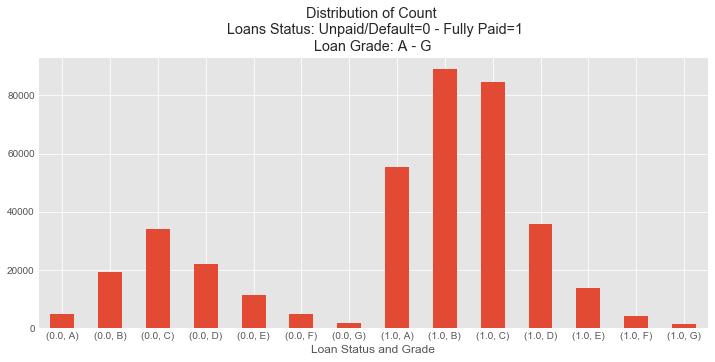

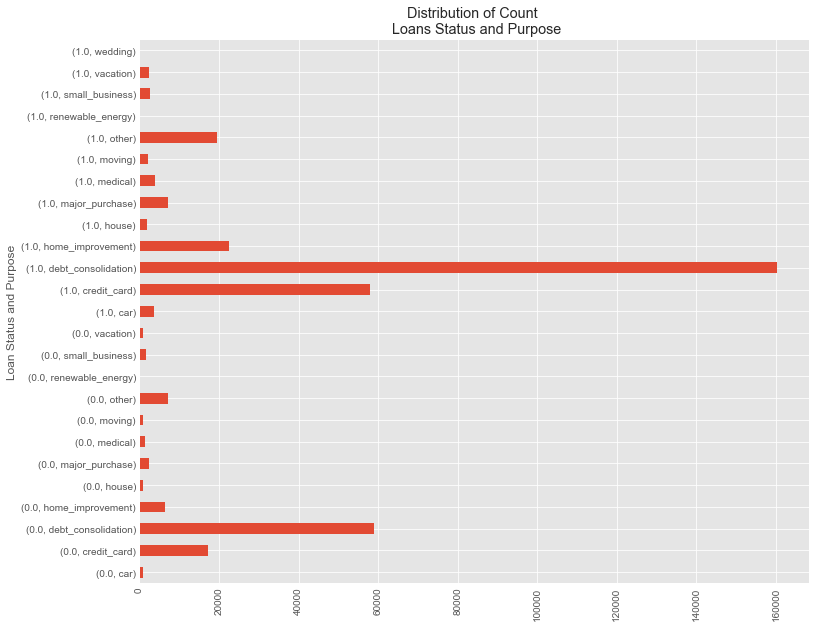

In [610]:
# groupby loans by status and grade and count records
ax = loans2.groupby(['loan_status','grade'])['grade'].count().plot(kind='bar',figsize=(12,5))
ax.set_title('Distribution of Count \n Loans Status: Unpaid/Default=0 - Fully Paid=1\nLoan Grade: A - G')
ax.set_xlabel('Loan Status and Grade')
plt.xticks(rotation=0)
plt.style.use('seaborn-dark')
plt.style.use('ggplot')
plt.show()

ax2 = loans2.groupby(['loan_status','purpose'])['purpose'].count().plot(kind='barh',figsize=(12,10))
ax2.set_title('Distribution of Count \n Loans Status and Purpose')
ax2.set_ylabel('Loan Status and Purpose')
plt.xticks(rotation=90)
plt.style.use('seaborn-dark')
plt.style.use('ggplot')
plt.show()

---------
## Select a random sample(15%) of the dataset
---------

In [551]:
# create a random sample of the dataframe from loans2
df = loans2.sample(frac=0.15, random_state=1023, replace=False)

In [552]:
print('Records in the random sample: ',len(df))
df.groupby('loan_status')['loan_status'].count()

Records in the random sample:  57394


loan_status
0.0    14994
1.0    42400
Name: loan_status, dtype: int64

In [553]:
# Select categorical columns only
categorical = df.select_dtypes(include=['object'])

#select every categorical columns except for emp_title due to ineffeciencies in encoding it
categorical = categorical[categorical.columns.difference(['emp_title'])]
categorical.head()

,addr_state,application_type,debt_settlement_flag,disbursement_method,earliest_cr_line,grade,hardship_flag,home_ownership,initial_list_status,issue_d,last_credit_pull_d,last_pymnt_d,purpose,pymnt_plan,sub_grade,term,title,verification_status
id,,,,,,,,,,,,,,,,,,
87315579,SC,Individual,N,Cash,January,C,N,MORTGAGE,w,August,January,January,debt_consolidation,n,C4,60 months,Debt consolidation,Not Verified
78139892,NY,Individual,N,Cash,October,C,N,OWN,w,June,January,July,debt_consolidation,n,C1,60 months,Debt consolidation,Source Verified
98102894,MI,Individual,N,Cash,June,C,N,OWN,f,February,July,May,debt_consolidation,n,C4,36 months,Debt consolidation,Source Verified
67476088,GA,Individual,N,Cash,January,C,N,MORTGAGE,w,December,March,January,debt_consolidation,n,C1,36 months,Debt consolidation,Source Verified
73893257,GA,Individual,N,Cash,May,A,N,MORTGAGE,w,March,March,March,debt_consolidation,n,A3,36 months,Debt consolidation,Not Verified


In [554]:
categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57394 entries, 87315579 to 91957040
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   addr_state            57394 non-null  object
 1   application_type      57394 non-null  object
 2   debt_settlement_flag  57394 non-null  object
 3   disbursement_method   57394 non-null  object
 4   earliest_cr_line      57394 non-null  object
 5   grade                 57394 non-null  object
 6   hardship_flag         57394 non-null  object
 7   home_ownership        57394 non-null  object
 8   initial_list_status   57394 non-null  object
 9   issue_d               57394 non-null  object
 10  last_credit_pull_d    57394 non-null  object
 11  last_pymnt_d          57394 non-null  object
 12  purpose               57394 non-null  object
 13  pymnt_plan            57394 non-null  object
 14  sub_grade             57394 non-null  object
 15  term                  5739

------------
## Categorical Encoding and Variable Selection
------------

In [555]:
categorical_encoded = categorical.head()
def encoder(data_frame):
    """ This function takes in a data frame and encodes all variables in it using pd.get_dummies.
    Initiallly an empty dataframe is created and then once each variable after encoding is concatenated to the empty dataframe.
    The empty dataframe has an index set to the index of the dataframe that the fucntion takes in. This is done so that the concatenation can be done on the index."""
    encoded_df = pd.DataFrame(index=data_frame.index)
    for i in list(data_frame.columns):
        encoded_df = pd.concat([encoded_df,pd.get_dummies(data_frame[i], prefix=i)], axis=1)
    return encoded_df

In [556]:
# categorical_columns encoded
encoded_categorical = encoder(categorical)

In [557]:
encoded_categorical_corr = encoded_categorical.corr()
# encoded_categorical_corr.head()

In [558]:
# Set a correlation threshold and remove variables based on this threshold and change correlation values to absolute values to be compared to the threshold
category_threshold = 0.5
encoded_categorical_corr_abs = abs(encoded_categorical_corr)

In [559]:
#upper triangle of the correlation matrix
upper = encoded_categorical_corr_abs.where(np.triu(np.ones(encoded_categorical_corr_abs.shape), k=1).astype(np.bool))
categories_to_drop = [col for col in upper.columns if any(upper[col]>category_threshold)]

In [560]:
print('Total numerical columns: ', len(list(encoded_categorical.columns)))
print('Columns to drop based on correlation threshold of', category_threshold, ' : ',len(categories_to_drop))

Total numerical columns:  187
Columns to drop based on correlation threshold of 0.5  :  26


In [561]:
#categorical data selection
categorical_select = encoded_categorical[encoded_categorical.columns.difference(categories_to_drop)]

-------------
## Numerical Variable Selection based on correlation threshold
-------------

In [562]:
numerical = df.select_dtypes(include=['float64'])
numerical.head()

,acc_now_delinq,acc_open_past_24mths,all_util,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collection_recovery_fee,collections_12_mths_ex_med,delinq_2yrs,delinq_amnt,dti,emp_length,fico_range_high,fico_range_low,funded_amnt,funded_amnt_inv,il_util,inq_fi,inq_last_12m,inq_last_6mths,installment,int_rate,last_fico_range_high,last_fico_range_low,last_pymnt_amnt,loan_amnt,max_bal_bc,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_rcnt_il,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,open_acc_6m,open_act_il,open_il_12m,open_il_24m,open_rv_12m,open_rv_24m,out_prncp,out_prncp_inv,pct_tl_nvr_dlq,percent_bc_gt_75,policy_code,pub_rec,pub_rec_bankruptcies,recoveries,revol_bal,revol_util,tax_liens,tot_coll_amt,tot_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bal_il,total_bc_limit,total_cu_tl,total_il_high_credit_limit,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,zip_code,loan_status
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
87315579,0.0,5.0,36.0,75000.0,22779.0,8103.0,67.8,0.0,0.0000,0.0,0.0,0.0,33.25,7.0,734.0,730.0,20000.0,20000.0,13.0,2.0,1.0,0.0,470.47,14.49,684.0,680.0,19456.77,20000.0,8944.0,154.0,187.0,10.0,10.0,5.0,10.0,10.0,10.0,4.0,3.0,3.0,3.0,11.0,7.0,5.0,15.0,3.0,9.0,0.0,0.0,0.0,2.0,9.0,0.0,3.0,1.0,3.0,1.0,2.0,0.0,0.0,85.2,33.3,1.0,0.0,0.0,0.00,17097.0,57.4,0.0,0.0,205013.0,250246.0,27.0,63188.0,46091.0,25200.0,3.0,76446.0,21322.552621,21322.55,1322.55,0.0,20000.00,29800.0,294.0,1.0
78139892,0.0,4.0,34.0,130000.0,58613.0,18718.0,39.6,0.0,710.1738,0.0,0.0,0.0,29.27,10.0,724.0,720.0,35000.0,35000.0,36.0,3.0,5.0,0.0,778.38,11.99,599.0,595.0,778.38,35000.0,6575.0,103.0,249.0,6.0,6.0,2.0,36.0,18.0,9.0,0.0,2.0,6.0,3.0,7.0,5.0,10.0,24.0,6.0,15.0,0.0,0.0,0.0,2.0,15.0,1.0,2.0,0.0,0.0,1.0,3.0,0.0,0.0,97.0,33.3,1.0,0.0,0.0,3945.41,498063.0,31.6,0.0,0.0,703353.0,794356.0,33.0,546366.0,14066.0,31000.0,0.0,38781.0,14041.040000,14041.04,4176.26,0.0,5919.37,545800.0,105.0,0.0
98102894,0.0,3.0,64.0,42000.0,11500.0,3818.0,71.7,0.0,0.0000,0.0,0.0,0.0,25.69,4.0,684.0,680.0,9600.0,9600.0,66.0,0.0,0.0,0.0,332.75,14.99,724.0,720.0,6498.90,9600.0,5016.0,109.0,236.0,19.0,18.0,2.0,18.0,19.0,19.0,0.0,3.0,4.0,3.0,10.0,9.0,5.0,18.0,4.0,11.0,0.0,0.0,0.0,0.0,11.0,0.0,5.0,0.0,2.0,0.0,1.0,0.0,0.0,96.4,33.3,1.0,0.0,0.0,0.00,12714.0,60.5,0.0,4112.0,126503.0,165500.0,29.0,32311.0,19597.0,13500.0,0.0,29500.0,11137.414485,11137.41,1537.41,0.0,9600.00,21000.0,495.0,1.0
67476088,0.0,8.0,87.0,74000.0,20560.0,55.0,98.8,0.0,0.0000,0.0,0.0,0.0,22.94,10.0,694.0,690.0,18000.0,17950.0,88.0,2.0,2.0,0.0,597.78,11.99,699.0,695.0,597.43,18000.0,2955.0,179.0,160.0,18.0,4.0,5.0,4.0,34.0,6.0,0.0,3.0,5.0,3.0,9.0,27.0,5.0,13.0,5.0,12.0,0.0,0.0,0.0,3.0,12.0,2.0,6.0,2.0,6.0,0.0,1.0,0.0,0.0,90.7,100.0,1.0,0.0,0.0,0.00,14151.0,81.8,0.0,0.0,246722.0,258489.0,45.0,68703.0,54552.0,4700.0,0.0,62109.0,21525.299004,21465.51,3525.30,0.0,18000.00,17300.0,305.0,1.0
73893257,0.0,0.0,60.0,165000.0,29248.0,2797.0,91.6,0.0,0.0000,0.0,0.0,0.0,17.80,10.0,714.0,710.0,25000.0,25000.0,46.0,0.0,0.0,0.0,771.59,6.97,704.0,700.0,771.37,25000.0,14859.0,177.0,235.0,27.0,27.0,5.0,33.0,27.0,18.0,0.0,3.0,3.0,5.0,12.0,4.0,10.0,20.0,3.0,13.0,0.0,0.0,0.0,0.0,13.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,96.6,60.0,1.0,0.0,0.0,0.00,30603.0,83.2,0.0,0.0,321725.0,394483.0,30.0,59850.0,29247.0,33400.0,0.0,63283.0,27767.342722,27767.34,2767.34,0.0,25000.00,36800.0,300.0,1.0


In [563]:
numerical[numerical.columns.difference(['loan_status'])].columns

Index(['acc_now_delinq', 'acc_open_past_24mths', 'all_util', 'annual_inc',
       'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths',
       'collection_recovery_fee', 'collections_12_mths_ex_med', 'delinq_2yrs',
       'delinq_amnt', 'dti', 'emp_length', 'fico_range_high', 'fico_range_low',
       'funded_amnt', 'funded_amnt_inv', 'il_util', 'inq_fi', 'inq_last_12m',
       'inq_last_6mths', 'installment', 'int_rate', 'last_fico_range_high',
       'last_fico_range_low', 'last_pymnt_amnt', 'loan_amnt', 'max_bal_bc',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_rcnt_il',
       'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
       'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_t

In [564]:
#correlations between numerical variables without loan status since that is the target variable
numerical_corr = numerical[numerical.columns.difference(['loan_status'])].corr()

In [565]:
# Set a correlation threshold and remove variables based on this threshold
threshold = 0.5
numerical_abs_corr = abs(numerical_corr)

# numerical_selection = abs_corr[abs_corr<=threshold]

In [566]:
#upper triangle of the correlation matrix
upper = numerical_abs_corr.where(np.triu(np.ones(numerical_abs_corr.shape), k=1).astype(np.bool))
numerical_to_drop = [col for col in upper.columns if any(upper[col]>threshold)]

In [567]:
print('Total numerical columns: ', len(list(numerical.columns)))
print('Columns to drop based on correlation threshold of', threshold, ' : ',len(numerical_to_drop))

Total numerical columns:  86
Columns to drop based on correlation threshold of 0.5  :  51


In [568]:
#numerical data selection
numerical_variables_select = list(numerical_corr.columns.difference(numerical_to_drop))
numerical_variables_select.append('loan_status')
numerical_select = numerical[numerical_variables_select]

In [569]:
# Selected numerical variables
print(numerical_select.info())
numerical_select.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57394 entries, 87315579 to 91957040
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   acc_now_delinq              57394 non-null  float64
 1   acc_open_past_24mths        57394 non-null  float64
 2   all_util                    57394 non-null  float64
 3   annual_inc                  57394 non-null  float64
 4   avg_cur_bal                 57394 non-null  float64
 5   chargeoff_within_12_mths    57394 non-null  float64
 6   collection_recovery_fee     57394 non-null  float64
 7   collections_12_mths_ex_med  57394 non-null  float64
 8   delinq_2yrs                 57394 non-null  float64
 9   delinq_amnt                 57394 non-null  float64
 10  dti                         57394 non-null  float64
 11  emp_length                  57394 non-null  float64
 12  funded_amnt                 57394 non-null  float64
 13  inq_fi               

,acc_now_delinq,acc_open_past_24mths,all_util,annual_inc,avg_cur_bal,chargeoff_within_12_mths,collection_recovery_fee,collections_12_mths_ex_med,delinq_2yrs,delinq_amnt,dti,emp_length,funded_amnt,inq_fi,inq_last_6mths,int_rate,last_fico_range_high,max_bal_bc,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,mths_since_rcnt_il,num_accts_ever_120_pd,num_actv_bc_tl,num_il_tl,num_tl_120dpd_2m,out_prncp,policy_code,pub_rec,tot_coll_amt,total_cu_tl,total_rec_late_fee,zip_code,loan_status
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
87315579,0.0,5.0,36.0,75000.0,22779.0,0.0,0.0000,0.0,0.0,0.0,33.25,7.0,20000.0,2.0,0.0,14.49,684.0,8944.0,154.0,187.0,10.0,5.0,10.0,4.0,3.0,7.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,294.0,1.0
78139892,0.0,4.0,34.0,130000.0,58613.0,0.0,710.1738,0.0,0.0,0.0,29.27,10.0,35000.0,3.0,0.0,11.99,599.0,6575.0,103.0,249.0,6.0,2.0,36.0,0.0,2.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,105.0,0.0
98102894,0.0,3.0,64.0,42000.0,11500.0,0.0,0.0000,0.0,0.0,0.0,25.69,4.0,9600.0,0.0,0.0,14.99,724.0,5016.0,109.0,236.0,19.0,2.0,18.0,0.0,3.0,9.0,0.0,0.0,1.0,0.0,4112.0,0.0,0.0,495.0,1.0
67476088,0.0,8.0,87.0,74000.0,20560.0,0.0,0.0000,0.0,0.0,0.0,22.94,10.0,18000.0,2.0,0.0,11.99,699.0,2955.0,179.0,160.0,18.0,5.0,4.0,0.0,3.0,27.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,305.0,1.0
73893257,0.0,0.0,60.0,165000.0,29248.0,0.0,0.0000,0.0,0.0,0.0,17.80,10.0,25000.0,0.0,0.0,6.97,704.0,14859.0,177.0,235.0,27.0,5.0,33.0,0.0,3.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,300.0,1.0


-----------
## Variable Transformation
-----------

In [570]:
from matplotlib import rcParams
rcParams['figure.figsize']= 10,3

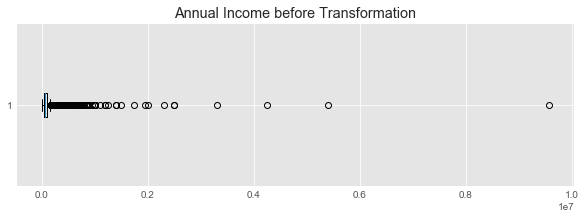

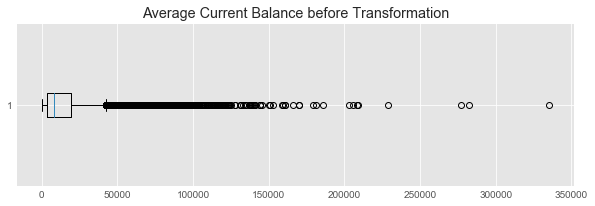

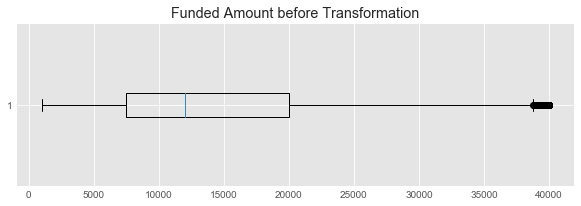

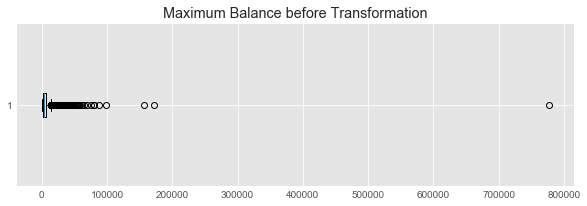

In [571]:
ax = plt.boxplot(numerical_select['annual_inc'], vert=False)
plt.style.use('seaborn-dark')
plt.style.use('ggplot')
plt.title('Annual Income before Transformation')
plt.show()

ax = plt.boxplot(numerical_select['avg_cur_bal'], vert=False)
plt.style.use('seaborn-dark')
plt.style.use('ggplot')
plt.title('Average Current Balance before Transformation')
plt.show()

ax = plt.boxplot(numerical_select['funded_amnt'], vert=False)
plt.style.use('seaborn-dark')
plt.style.use('ggplot')
plt.title('Funded Amount before Transformation')
plt.show()

ax = plt.boxplot(numerical_select['max_bal_bc'], vert=False)
plt.style.use('seaborn-dark')
plt.style.use('ggplot')
plt.title('Maximum Balance before Transformation')
plt.show()

In [572]:
from sklearn.preprocessing import power_transform
numerical_select['annual_inc'] = np.log(numerical_select['annual_inc'])
numerical_select['avg_cur_bal'] = power_transform(pd.DataFrame(numerical_select['avg_cur_bal']), method='yeo-johnson')
numerical_select['funded_amnt'] = power_transform(pd.DataFrame(numerical_select['funded_amnt']), method='box-cox')
numerical_select['max_bal_bc'] = power_transform(pd.DataFrame(numerical_select['max_bal_bc']), method='yeo-johnson')

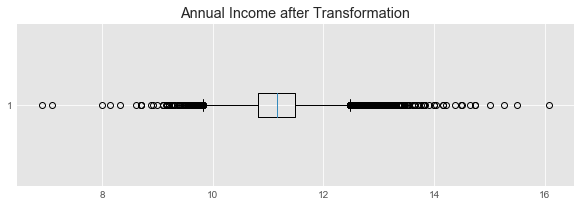

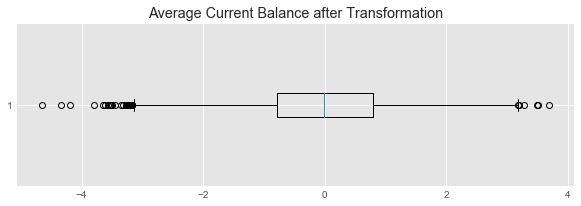

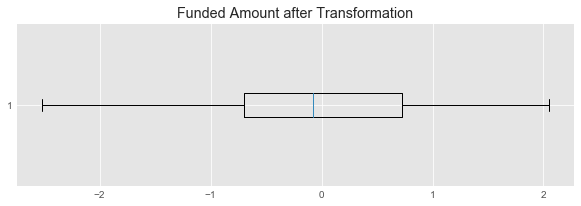

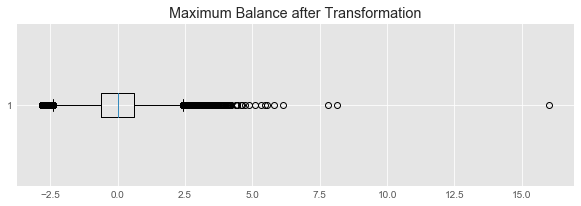

In [573]:
ax = plt.boxplot(numerical_select['annual_inc'], vert=False)
plt.style.use('seaborn-dark')
plt.style.use('ggplot')
plt.title('Annual Income after Transformation')
plt.show()

ax = plt.boxplot(numerical_select['avg_cur_bal'], vert=False)
plt.style.use('seaborn-dark')
plt.style.use('ggplot')
plt.title('Average Current Balance after Transformation')
plt.show()

ax = plt.boxplot(numerical_select['funded_amnt'], vert=False)
plt.style.use('seaborn-dark')
plt.style.use('ggplot')
plt.title('Funded Amount after Transformation')
plt.show()

ax = plt.boxplot(numerical_select['max_bal_bc'], vert=False)
plt.style.use('seaborn-dark')
plt.style.use('ggplot')
plt.title('Maximum Balance after Transformation')
plt.show()

----------
## Combine categorical and numerical data after pre-processing and variable selection
----------

In [574]:
# combine numerical and categorical data 
model_data = pd.concat([categorical_select, numerical_select], axis=1)
model_data.head()

,addr_state_AK,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,application_type_Individual,debt_settlement_flag_N,disbursement_method_Cash,earliest_cr_line_April,earliest_cr_line_August,earliest_cr_line_December,earliest_cr_line_February,earliest_cr_line_January,earliest_cr_line_July,earliest_cr_line_June,earliest_cr_line_March,earliest_cr_line_May,earliest_cr_line_November,earliest_cr_line_October,earliest_cr_line_September,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,hardship_flag_N,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OWN,initial_list_status_f,issue_d_April,issue_d_August,issue_d_December,issue_d_February,issue_d_January,issue_d_July,issue_d_June,issue_d_March,issue_d_May,issue_d_November,issue_d_October,issue_d_September,last_credit_pull_d_April,last_credit_pull_d_August,last_credit_pull_d_December,last_credit_pull_d_February,last_credit_pull_d_January,last_credit_pull_d_July,last_credit_pull_d_June,last_credit_pull_d_March,last_credit_pull_d_May,last_credit_pull_d_November,last_credit_pull_d_October,last_credit_pull_d_September,last_pymnt_d_April,last_pymnt_d_August,last_pymnt_d_December,last_pymnt_d_February,last_pymnt_d_January,last_pymnt_d_July,last_pymnt_d_June,last_pymnt_d_March,last_pymnt_d_May,last_pymnt_d_November,last_pymnt_d_October,last_pymnt_d_September,purpose_car,purpose_credit_card,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,term_ 36 months,title_Credit Card Consolidation,verification_status_Not Verified,acc_now_delinq,acc_open_past_24mths,all_util,annual_inc,avg_cur_bal,chargeoff_within_12_mths,collection_recovery_fee,collections_12_mths_ex_med,delinq_2yrs,delinq_amnt,dti,emp_length,funded_amnt,inq_fi,inq_last_6mths,int_rate,last_fico_range_high,max_bal_bc,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,mths_since_rcnt_il,num_accts_ever_120_pd,num_actv_bc_tl,num_il_tl,num_tl_120dpd_2m,out_prncp,policy_code,pub_rec,tot_coll_amt,total_cu_tl,total_rec_late_fee,zip_code,loan_status
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
87315579,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,5.0,36.0,11.225243,0.964369,0.0,0.0000,0.0,0.0,0.0,33.25,7.0,0.725566,2.0,0.0,14.49,684.0,0.919072,154.0,187.0,10.0,5.0,10.0,4.0,3.0,7.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,294.0,1.0
78139892,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,

--------------
## Train Test Split and Modeling
--------------

In [575]:
from sklearn.model_selection import train_test_split

In [576]:
#define endog(y) and exog(x) variables
x = model_data.iloc[:,:-1]
y = model_data.iloc[:,[-1]]

In [577]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [609]:
len(list(model_data.columns))

196

--------------
## Logistic Regression
--------------

In [578]:
# Fit a logistic Model
from sklearn.linear_model import LogisticRegression

# instantiatiate a class of the logistic model
logit_model = LogisticRegression()
#fit the class to the training data
logit_fit = logit_model.fit(x_train, y_train)

In [579]:
#make predictions on the holdout set(test set)
logit_predict = logit_fit.predict(x_test)

Simple accuracy score of the model:  0.9293492464500392
AUC accuracy score of the model:  0.8758636496335412

Logit Regression Confusion Matrix:
 Predicted   0.0   1.0    All
Actual                      
0.0        2285   705   2990
1.0         106  8383   8489
All        2391  9088  11479


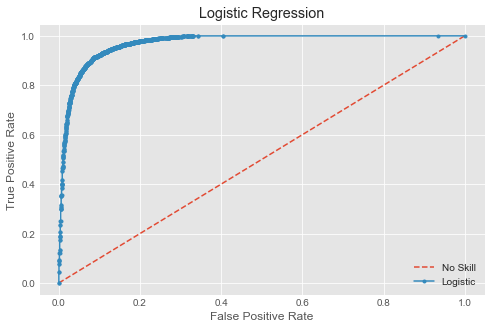

In [593]:
#get the accuracy of predictions - evaluate the model using AUC
from sklearn.metrics import roc_auc_score, roc_curve

#simple accuracy
logit_accuracy = logit_fit.score(x_test,y_test)
print('Simple accuracy score of the model: ',logit_accuracy)

#auc accuracy score
logit_auc_score = roc_auc_score(y_test.values, logit_predict)
print('AUC accuracy score of the model: ',logit_auc_score)

#Confusion Matrix
logit_confusion_matrix = pd.crosstab(y_test.values.reshape(-1), logit_predict.reshape(-1), rownames=['Actual'], colnames=['Predicted'], margins=True)
print('\nLogit Regression Confusion Matrix:\n',logit_confusion_matrix)

#get probabilities from model
logit_probs = logit_fit.predict_proba(x_test)[:,1]

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test.values, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test.values, logit_probs)

rcParams['figure.figsize'] = 8,5
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
plt.title('Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

---------
## Naive Bayes
---------

In [594]:
from sklearn.naive_bayes import GaussianNB

In [595]:
#instantiate a class of svm
nb_model = GaussianNB()
nb_fit = nb_model.fit(x_train, y_train)

In [596]:
#make predictions on the holdout set(test set)
nb_predict = nb_fit.predict(x_test)

Simple accuracy score of the model:  0.9141911316316752
AUC accuracy score of the model:  0.8397255783699622

Naive Bayes Confusion Matrix:
 Predicted   0.0   1.0    All
Actual                      
0.0        2046   944   2990
1.0          41  8448   8489
All        2087  9392  11479


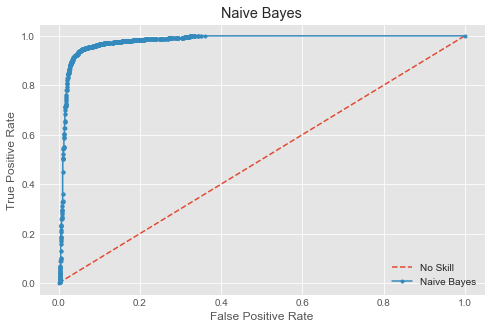

In [597]:
#get the accuracy of predictions - evaluate the model using AUC
from sklearn.metrics import roc_auc_score

#simple accuracy
nb_accuracy = nb_fit.score(x_test,y_test)
print('Simple accuracy score of the model: ',nb_accuracy)

#auc accuracy score
nb_auc_score = roc_auc_score(y_test.values, nb_predict)
print('AUC accuracy score of the model: ',nb_auc_score)

#Confusion Matrix
nb_confusion_matrix = pd.crosstab(y_test.values.reshape(-1), nb_predict.reshape(-1), rownames=['Actual'], colnames=['Predicted'], margins=True)
print('\nNaive Bayes Confusion Matrix:\n',nb_confusion_matrix)

#get probabilities from the model
nb_probs = nb_fit.predict_proba(x_test)[:,1]

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test.values, ns_probs)
nb_fpr, nb_tpr, _ = roc_curve(y_test.values, nb_probs)

rcParams['figure.figsize'] = 8,5
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(nb_fpr, nb_tpr, marker='.', label='Naive Bayes')

# axis labels
plt.title('Naive Bayes')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

--------
## Random Forest
-------

In [598]:
from sklearn.ensemble import RandomForestClassifier

In [599]:
rf_model = RandomForestClassifier()
rf_fit = rf_model.fit(x_train, y_train)

In [600]:
#make predictions
rf_predict = rf_fit.predict(x_test)

Simple accuracy score of the model:  0.9648052966286262
AUC accuracy score of the model:  0.9560561749988477

Random Forest Confusion Matrix:
 Predicted   0.0   1.0    All
Actual                      
0.0        2804   186   2990
1.0         218  8271   8489
All        3022  8457  11479


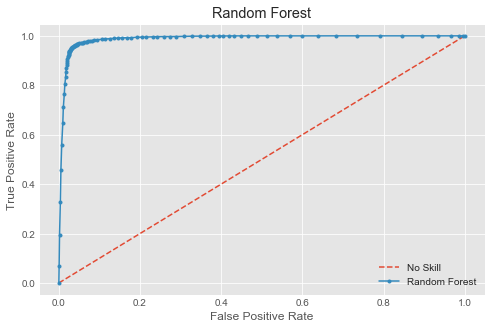

In [601]:
#get the accuracy of predictions - evaluate the model using AUC
from sklearn.metrics import roc_auc_score

#simple accuracy
rf_accuracy = rf_fit.score(x_test,y_test)
print('Simple accuracy score of the model: ',rf_accuracy)

#auc accuracy score
rf_auc_score = roc_auc_score(y_test.values, rf_predict)
print('AUC accuracy score of the model: ',rf_auc_score)

#Confusion Matrix
rf_confusion_matrix = pd.crosstab(y_test.values.reshape(-1), rf_predict.reshape(-1), rownames=['Actual'], colnames=['Predicted'], margins=True)
print('\nRandom Forest Confusion Matrix:\n',rf_confusion_matrix)

#get probabilities from the model
rf_probs = rf_fit.predict_proba(x_test)[:,1]

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test.values, ns_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test.values, rf_probs)

rcParams['figure.figsize'] = 8,5
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')

# axis labels
plt.title('Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

---------
## k-nearest neighbor
---------

In [602]:
from sklearn.neighbors import KNeighborsClassifier

In [603]:
knn_model = KNeighborsClassifier()
knn_fit = knn_model.fit(x_train, y_train)

In [604]:
#make predictions
knn_predict = knn_fit.predict(x_test)

Simple accuracy score of the model:  0.9474692917501525
AUC accuracy score of the model:  0.9225619343703105

k-nearest neighbors Confusion Matrix:
 Predicted   0.0   1.0    All
Actual                      
0.0        2603   387   2990
1.0         216  8273   8489
All        2819  8660  11479


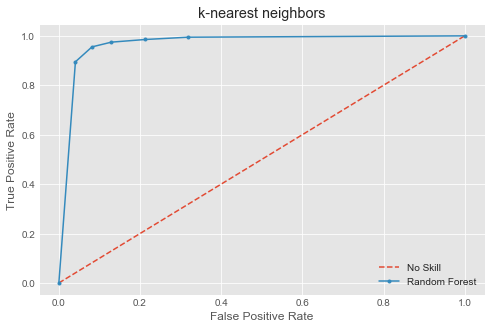

In [605]:
#simple accuracy
knn_accuracy = knn_fit.score(x_test,y_test)
print('Simple accuracy score of the model: ',knn_accuracy)

#auc accuracy score
knn_auc_score = roc_auc_score(y_test.values, knn_predict)
print('AUC accuracy score of the model: ',knn_auc_score)

#Confusion Matrix
knn_confusion_matrix = pd.crosstab(y_test.values.reshape(-1), knn_predict.reshape(-1), rownames=['Actual'], colnames=['Predicted'], margins=True)
print('\nk-nearest neighbors Confusion Matrix:\n',knn_confusion_matrix)

#get probabilities from the model
knn_probs = knn_fit.predict_proba(x_test)[:,1]

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test.values, ns_probs)
knn_fpr, knn_tpr, _ = roc_curve(y_test.values, knn_probs)

rcParams['figure.figsize'] = 8,5
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(knn_fpr, knn_tpr, marker='.', label='Random Forest')

# axis labels
plt.title('k-nearest neighbors')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()